In [12]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt

# Data

## Define path and load csv data

In [13]:
root_to_train_img = "../input/siim-isic-melanoma-classification/jpeg/"
root_to_train_csv = "../input/siim-isic-melanoma-classification/train.csv"
df = pd.read_csv(root_to_train_csv, engine="python")

## Have a look at the data

In [14]:
# Have a look at the data
# plot 5 random images 
import random
import glob
# a = random.choices(glob.glob(root_to_train_img + "train/*"), k=5)
# for i in a:
#     print(i)
#     img = cv2.imread(i)
#     img_name = i.split("/")[-1][:-4]
#     print(img_name)
#     plt.imshow(img)
#     plt.show()
#     print(f"{img_name}")
#     print("-"*100)

## Preprocess CSV Data

[INFO] Binarizing sex
[INFO] Taking care of Age
[INFO] Taking care of anatom...
[INFO] One hot encoding


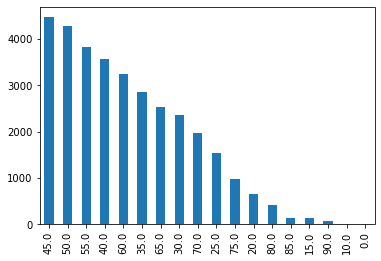

In [15]:
df = pd.read_csv(root_to_train_csv, engine="python")
df.head()

df = df.drop("patient_id", axis=1)

# sex is binary so can be binarized
print("[INFO] Binarizing sex")
def binarize_sex(row):
    if row['sex'] == 'male':
        return 0
    else:
        return 1

df['sex'] = df.apply(lambda x: binarize_sex(x), axis=1)

# Take care of nan values in age
print("[INFO] Taking care of Age")
df['age_approx'].value_counts().plot(kind='bar')
x1 = df.loc[df["benign_malignant"] == "benign", 'age_approx']
x2 = df.loc[df["benign_malignant"] == "malignant", 'age_approx']

benign_mean = np.nanmean(x1)
benign_std = np.nanstd(x1)
malignant_mean = np.nanmean(x2)
malignant_std = np.nanstd(x2)

def fillna(row):
    if np.isnan(row['age_approx']):
        if row['benign_malignant'] == 'benign':
            return np.random.normal(loc=benign_mean, scale=benign_std)
        else:
            return np.random.normal(loc=malignant_mean, scale=malignant_std)
    else:
        return row['age_approx']
    
# encode age
def encodeage(row):
    if row['age_approx'] >=40 and row['age_approx'] <=60:
        return "highly likely"
    elif row['age_approx'] <=25 or row['age_approx'] >=75:
        return "least likely"
    else:
        return "average"

df['age_approx'] = df.apply(lambda x: fillna(x), axis=1)
# From the image we can roughly make three broad classes
#     1. >40 <60 -- highly likely
#     2. <25 >75 -- least likely
#     3. rest -- average likelihood
df['age'] = df.apply(lambda x: encodeage(x), axis=1)
df.drop("age_approx", axis=1, inplace=True)

# take care of anatom_site_general_challenge
# nan values replaced by probabilistically choosing  
# one of the distinct values.
print("[INFO] Taking care of anatom...")
x1 = df.loc[df["benign_malignant"] == "benign", 'anatom_site_general_challenge']
x2 = df.loc[df["benign_malignant"] == "malignant", 'anatom_site_general_challenge']
distinct = list(set(df['anatom_site_general_challenge'].values))
distinct = distinct[1:]
di = dict()
for i in distinct:
    di[i] = 0

for i in x1:
    if i in di.keys():
        di[i] += 1

tot_sum = 0
for _, val in di.items():
    tot_sum += val
prob_benign = []
for i in distinct:
    prob_benign.append(di[i]/tot_sum)

di2 = dict()
for i in distinct:
    di2[i] = 0

for i in x2:
    if i in di2.keys():
        di2[i]+=1

tot_sum = 0
for _, val in di2.items():
    tot_sum += val
prob_malignant = []
for i in distinct:
    prob_malignant.append(di2[i]/tot_sum)

def fillna(row):
    if isinstance(row['anatom_site_general_challenge'], float):
        if row['benign_malignant'] == 'benign':
            return np.random.choice(distinct, p=prob_benign)
        else:
            return np.random.choice(distinct, p=prob_malignant)
        print("Not Both")
    else:
        return row['anatom_site_general_challenge']

df['anatom_site_general_challenge'] = df.apply(lambda x: fillna(x), axis=1)

save_info = {
    "age":{
        "benign_mean" : benign_mean,
        "benign_std" : benign_std,
        "malignant_mean": malignant_mean,
        "malignant_std" : malignant_std
    },
    "anatom":{
        "distinct":distinct,
        "prob_benign":prob_benign,
        "prob_malignant":prob_malignant
    },
    "desc": """ There are two charachteristics stored here age and anatom in form of dictionaries.\n 
    age has 4 keys benign_mean, benign_std, malignant_mean, malignant_std\n
    anatom has 3 keys distinct, prob_benign, prob_malignant."""
}

# save the required files can later be used in converting test dataset
# with open("../input/siim-isic-melanoma-classification/save_info", "wb") as f:
#     pkl.dump(save_info, f)

print("[INFO] One hot encoding")
# Get dummy variables
# Preferrable use OneHotEncoding from sklearn, here i am using 
# get dummy variables by pandas
df = pd.concat([df, pd.get_dummies(df['anatom_site_general_challenge'])], axis=1).drop(["anatom_site_general_challenge"], axis=1)
df = pd.concat([df, pd.get_dummies(df['diagnosis'])], axis=1).drop(["diagnosis"], axis=1)
df = pd.concat([df, pd.get_dummies(df['age'])], axis=1).drop('age', axis=1)
target = df[["target"]]
df.drop(["target", "benign_malignant"], axis=1, inplace=True)
df = pd.concat([df, target], axis=1)

# Custom Dataset Class for PyTorch Model

In [16]:
from PIL import Image

class SIIMTrainDataset(Dataset):
    def __init__(self, root_img, df, transforms, shuffle):
        self.img_files = glob.glob(root_img + "train/*")
        self.df = df
        self.idx = list(range(len(self.img_files)))
        self.len = len(self.df)
        
        if shuffle:
            self.shuffledidx = list(range(len(self.img_files)))
            random.shuffle(self.shuffledidx)
        
        print(len(self.shuffledidx))
        self.transforms = transforms
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        real_idx = self.shuffledidx[idx]
        img_path = self.img_files[real_idx]
        img_name = self.img_files[real_idx].split("/")[-1][:-4]
        
        img = cv2.imread(img_path)
        img = Image.fromarray(img)
        details = df.loc[df["image_name"] == img_name]
        label = details['target'].values
        details = details.drop('image_name', axis=1)
        details = details.values.reshape(-1,)

        # apply transforms on image
        if self.transforms is not None:
            img = self.transforms(img)
        
        return (img, details, label)

## Test the class

In [17]:
transforms = T.Compose(
    [
        T.Resize((600, 600)),
        T.RandomHorizontalFlip(),
        T.RandomCrop(224),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

rawdataset = SIIMTrainDataset(root_to_train_img, df, transforms, True)
idx = random.choice(list(range(len(rawdataset))))
img, details, label = rawdataset.__getitem__(idx)
print(img.shape)
print(details.shape)
print(label.shape)

33126
torch.Size([3, 224, 224])
(20,)
(1,)


In [18]:
dataloader = DataLoader(rawdataset, batch_size=64, shuffle=True)
img, details, label = next(iter(dataloader))
print(img.shape)
print(details.shape)
print(label.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64, 20])
torch.Size([64, 1])


# Model

Thought out architecture

ConvModel --> Feature Extractor
Flatten the output of ConvModel

DenseModel --> Feature Extractor from linear details

DenseModel2 --> Concat out of Conv and DenseModel

## Conv Model

In [19]:
# Basic Conv Model
# class ConvModel(nn.Module):
#     def __init__(self, input_c):
#         super(ConvModel, self).__init__()
        
#         blocks = []
#         blocks.append(nn.Conv2d(input_c, 64, (3,3)))
#         in_c = 64
#         for _ in range(3):
#             blocks.append(nn.Conv2d(in_c, in_c*2, 7))
#             blocks.append(nn.BatchNorm2d(in_c*2))
#             blocks.append(nn.ReLU(inplace=True))
#             blocks.append(nn.MaxPool2d(3))
#             in_c = in_c*2
            
#         for _ in range(2):
#             blocks.append(nn.Conv2d(in_c, in_c, 3, padding=0))
#             blocks.append(nn.BatchNorm2d(in_c))
#             blocks.append(nn.ReLU(inplace=True))
        
#         blocks.append(nn.Flatten())
#         self.net = nn.Sequential(*blocks)
        
#     def forward(self, x):
#         return self.net(x)

    
# Pretrained Conv Model
from torchvision.models import resnet50
conv = resnet50(pretrained=True)
for i in conv.parameters():
    i.requires_grad = False

blocks = list(conv.children())[:-3][:-1]

class ConvModel(nn.Module):
    def __init__(self, blocks):
        super(ConvModel, self).__init__()
        
        blocks.append(nn.Conv2d(512, 512, 7))
        blocks.append(nn.BatchNorm2d(512))
        blocks.append(nn.MaxPool2d(3))
        
        blocks.append(nn.Conv2d(512, 512, 3))
        blocks.append(nn.BatchNorm2d(512))
        blocks.append(nn.MaxPool2d(3))
        
        blocks.append(nn.Flatten())


        self.net = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.net(x)
    
    
# Dense Model 1
class DenseModelA(nn.Module):
    def __init__(self, input_dim):
        super(DenseModelA, self).__init__()
        
        blocks = []
        blocks.append(nn.Linear(input_dim, 64))
        blocks.append(nn.ReLU(inplace=True))
        in_c = 64
        for _ in range(3):
            blocks.append(nn.Linear(in_c, in_c*2))
            blocks.append(nn.ReLU(inplace=True))
            in_c = in_c*2
        
        self.net = nn.Sequential(*blocks)
        
    def forward(self, x):
        return self.net(x)
    
# Dense Model 2
class DenseModelB(nn.Module):
    def __init__(self, input_dim):
        super(DenseModelB, self).__init__()
        
        blocks = []
        while input_dim >4:
            blocks.append(nn.Linear(input_dim, input_dim//4))
            blocks.append(nn.ReLU(inplace=True))
            input_dim = input_dim // 4
                
        blocks.append(nn.Linear(input_dim, 1))
        blocks.append(nn.Softmax(dim=-1))
        
        self.net = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.net(x)

# Final Model
class FinalModel(nn.Module):
    def __init__(self, conv, denseA, denseB):
        super(FinalModel, self).__init__()
        
        self.conv = conv
        self.denseA = denseA
        self.denseB = denseB
        
    def forward(self, x, y):
        x = self.conv(x)
        y = self.denseA(y)
        out = x + y
        out = self.denseB(out)
        return out

In [20]:
conv = ConvModel(blocks)
denseA = DenseModelA(20)
denseB = DenseModelB(512)

if torch.cuda.is_available():
    conv = conv.cuda()
    denseA = denseA.cuda()
    denseB = denseB.cuda()

final = FinalModel(conv, denseA, denseB)

if torch.cuda.is_available():
    final = final.cuda()

In [21]:
for i in denseA.parameters():
    print(i.size())

torch.Size([64, 20])
torch.Size([64])
torch.Size([128, 64])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([512, 256])
torch.Size([512])


# Training loop

Try with a common optimizer

In [22]:
from time import time
optimizer = optim.Adam(final.parameters(), lr=1e-4)
criterion = nn.BCELoss()
tot_time = 0
for _ in range(10):
    running_loss = 0.0
    for batch, (img, details, label) in enumerate(dataloader):
        start = time()
        
        img = img.float()
        details = details.float()
        label = label.float()
        
        if torch.cuda.is_available():
            img = img.cuda()
            details = details.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()
        
        pred = final(img, details)
        loss = criterion(pred, label)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        tot_time += time()-start
        if batch % 10 == 9:
            print(f"Done [{batch+1}/{len(dataloader)}] batches time required = {tot_time}")
            tot_time = 0
    
    print(f"epoch = {_} loss = {running_loss / len(rawdataset)}")

Done [10/518] batches time required = 1.0577387809753418
Done [20/518] batches time required = 1.0494811534881592
Done [30/518] batches time required = 1.0569958686828613
Done [40/518] batches time required = 1.0623228549957275
Done [50/518] batches time required = 1.0524938106536865
Done [60/518] batches time required = 1.0711050033569336
Done [70/518] batches time required = 1.0590739250183105
Done [80/518] batches time required = 1.0533688068389893
Done [90/518] batches time required = 1.0721418857574463
Done [100/518] batches time required = 1.0594682693481445
Done [110/518] batches time required = 1.0550408363342285
Done [120/518] batches time required = 1.0626990795135498
Done [130/518] batches time required = 1.0548985004425049
Done [140/518] batches time required = 1.0730366706848145
Done [150/518] batches time required = 1.057999610900879
Done [160/518] batches time required = 1.0556516647338867
Done [170/518] batches time required = 1.055018663406372
Done [180/518] batches ti

KeyboardInterrupt: 